In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import time
%matplotlib inline

In [24]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')

In [25]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [28]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Content-base Method

In [54]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna('').astype('str')

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

/Users/rui/anaconda/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(9742, 177)

In [56]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])

In [57]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [58]:
genre_recommendations('Toy Story (1995)').head(20)

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
8927                             The Good Dinosaur (2015)
9430                                         Moana (2016)
5490    Twelve Tasks of Asterix, The (Les douze travau...
6448           TMNT (Teenage Mutant Ninja Turtles) (2007)
8357                                The Lego Movie (2014)
3194                                         Shrek (2001)
7530                               Gnomeo & Juliet (2011)
7805        Pu

# ALS Method

In [29]:
rating_data = ratings.drop(['timestamp'], axis = 1)

In [30]:
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [31]:
num_users = np.union1d(ratings['userId'], tags['userId']).shape[0]
num_users

610

In [32]:
num_movies_rated = ratings['movieId'].unique().shape[0]
num_movies_rated

9724

In [40]:
# We will use a num_users x num_movies_rated matrix to represent the ratings, in which zeros are the user-movie pairs 
# without a rating.

ratings_matrix = np.zeros((num_users, num_movies_rated))

usersId = np.sort(ratings.userId.unique())
moviesId = np.sort(ratings.movieId.unique())

for i in range(len(rating_data)):
    user = rating_data.iloc[i, 0]
    movie = rating_data.iloc[i, 1]
    ratings_matrix[usersId == user, moviesId == movie] = rating_data.iloc[i, 2]
    
ratings_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [39]:
ratings_matrix.shape

(610, 9724)

In [41]:
# Now we split the data into training/validation/testing sets using a 6/2/2 ratio. We use a for loop to split the 
# existing ratings for each user. Because the minimum number of ratings per user is 20, each user will have at least 
# 12, 4, and 4 ratings in the training, validation, and testing sets, respectively.

import random
random.seed(0)

def data_split(ratings, ratio):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        index = ratings[user, :].nonzero()[0]
        k = int(round(len(index) * ratio))
        test_ratings = random.sample(index, k)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [42]:
train_matrix, tmp = data_split(ratings_matrix, 0.4)
validation_matrix, test_matrix = data_split(tmp, 0.5)

In [43]:
print 'Number of ratings in the training set:', (train_matrix > 0).sum()
print 'Number of ratings in the validation set:', (validation_matrix > 0).sum()
print 'Number of ratings in the testing set:', (test_matrix > 0).sum()

Number of ratings in the training set: 60521
Number of ratings in the validation set: 20031
Number of ratings in the testing set: 20284


In [48]:
# Now we’ll build a ALS model. The implementation below is borrowed and modified from here. One main modification is 
# that we train the model with the mean subtracted ratings here. At the prediction step, the mean rating will be added 
# back. This approach makes it easier for the model to converge.

from numpy.linalg import solve

class ALS(object):
    
    def __init__(self, ratings, n_factors=10, reg=0.0, verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        reg : (float)
            Regularization term for both user and item latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        # we will train the model with the mean subtracted ratings, and 
        # at the prediction step, the mean will be added back. 
        self.raw_ratings = ratings
        self.mean = ratings[ratings > 0].mean()
        self.ratings = ratings.copy() 
        self.ratings[ratings > 0] = self.ratings[ratings > 0] - self.mean
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.reg = reg
        self._v = verbose

    def als_step(self, latent_vectors, fixed_vecs, ratings, _lambda, type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute for the item latent vectors
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                #latent_vectors[u, :] = (solve((YTY + lambdaI).T, (ratings[u, :].dot(fixed_vecs)).T)).T
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # input your code here to get the Y matrix
            # think about the function 2
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors using a normal distribution centered at 0
        self.user_vecs = np.random.normal(0,1,(self.n_users, self.n_factors)) 
        self.item_vecs = np.random.normal(0,1,(self.n_items, self.n_factors)) 
       
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        count = 1
        while count <= n_iter:
            if count % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(count)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.reg, 
                                           type='item')
            count += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = self.user_vecs.dot(self.item_vecs.T) + self.mean        
        return predictions
    
    def calculate_learning_curve(self, iter_array, valid):
        """
        Keep track of RMSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        valid : (2D ndarray)
            Validation dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data RMSE values for each value of iter_array
        valid_rmse : (list)
            Validation data RMSE values for each value of iter_array
        """
        self.iter_array = iter_array
        self.iter_array.sort()
        self.train_rmse =[]
        self.valid_rmse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(self.iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_rmse += [get_rmse(predictions, self.raw_ratings)]
            self.valid_rmse += [get_rmse(predictions, valid)]
            if self._v:
                print 'Train RMSE: ' + str(self.train_rmse[-1])
                print 'Validation RMSE: ' + str(self.valid_rmse[-1])
            iter_diff = n_iter

    def plot_learning_curve(self):
        """ Plot the learning curves """
        plt.plot(self.iter_array, self.train_rmse, label='Training', linewidth=5)
        plt.plot(self.iter_array, self.valid_rmse, label='Validation', linewidth=5)
        plt.xticks(range(0, max(self.iter_array) + 1, 2), fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('iterations', fontsize=30)
        plt.ylabel('RMSE', fontsize=30)
        plt.legend(loc='best', fontsize=20) 
        plt.show()

def get_rmse(predictions, ratings):
    """ Calculate RMSE for predicted ratings"""
    diff = (predictions - ratings)[ratings > 0]
    return np.sqrt((diff**2).mean())

In [49]:
# With the ALS model, we can use a grid search to find the optimal hyperparameters.
latent_factors = [6, 8, 10, 12, 14]
regularizations = [0.05, 0.1, 0.2, 0.4, 0.8]
iter_array = [10, 25]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['valid_rmse'] = np.inf
best_params['model'] = None

start_time = time.time()

for fact in latent_factors:
    for reg in regularizations:
        MF_ALS = ALS(train_matrix, n_factors = fact, reg = reg)
        MF_ALS.calculate_learning_curve(iter_array, validation_matrix)
        min_idx = np.argmin(MF_ALS.valid_rmse)
      
        if MF_ALS.valid_rmse[min_idx] < best_params['valid_rmse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_rmse'] = MF_ALS.train_rmse[min_idx]
            best_params['valid_rmse'] = MF_ALS.valid_rmse[min_idx]
            best_params['model'] = MF_ALS
            print 'New optimal hyperparameters'
            print pd.Series(best_params)
        

print '\nThe best model has {} latent factors and regularization = {}'.format(\
        best_params['n_factors'], best_params['reg'])        
print 'Total Runtime: {:.2f} seconds'.format(time.time() - start_time)

New optimal hyperparameters
model         <__main__.ALS object at 0x11a8a2350>
n_factors                                        6
n_iter                                          25
reg                                           0.05
train_rmse                                0.934957
valid_rmse                                 1.01314
dtype: object
New optimal hyperparameters
model         <__main__.ALS object at 0x11a8c5290>
n_factors                                        6
n_iter                                          10
reg                                            0.2
train_rmse                                0.933964
valid_rmse                                 1.01254
dtype: object
New optimal hyperparameters
model         <__main__.ALS object at 0x11a874550>
n_factors                                        6
n_iter                                          10
reg                                            0.4
train_rmse                                0.934085
valid_rmse           

In [50]:
best_model = best_params['model']
iter_array = [1, 2, 5, 10]

In [51]:
best_model.calculate_learning_curve(iter_array, validation_matrix)

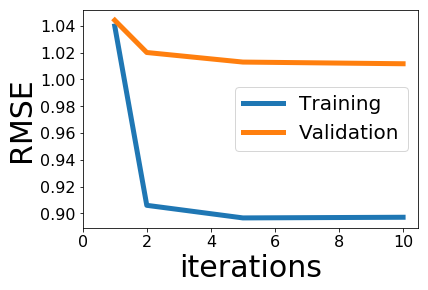

In [52]:
best_model.plot_learning_curve()

In [53]:
print 'For testing data the RMSE is {}'.format(get_rmse(best_model.predict_all(), test_matrix))

For testing data the RMSE is 1.01191482559
